This notebook is meant for the CLUSTER version of analysis, for the purposes of creating an entropy profile that mimics the Phoenix cluster and similar clusters that lack an AGN that heats against the cooling flow.

Finish the presentation with data/future work - LOOK FOR (better) VIRGO DATA!

In [49]:
import random
import statistics
import matplotlib.pyplot as plt
import numpy as np
#from scipy.integrate import odeint
#from scipy.stats import linregress
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from scipy.constants import k as k_B  # Boltzmann constant in J/K
from scipy.constants import G, proton_mass
from functools import partial
import lab_functions_1 as lf
from numba import njit
mp_g = proton_mass*1e3
k_Bcgs = k_B*1e7
mu = 0.593
gamma = 5/3
ktc = 3.0857e21
etkv = 6.2415*10**8
kevtk = 1.16*10**7
z = 0.597
Mdot1 = 6.30391e25

In [50]:
radii_grid = np.linspace(0.1*ktc, 20000*ktc, 75000)
vc_grid = np.array([lf.vcgrab(r, z, 3e12, 2e15) for r in radii_grid])
vc_interp = interp1d(radii_grid, vc_grid, kind='cubic', fill_value='extrapolate')

In [51]:
from scipy.integrate import cumulative_trapezoid
r_grid = np.geomspace(ktc*0.001, 28518000 * ktc, 14000)  # finer grid = better accuracy
vc2_over_r = np.array([(lf.vcgrab(r, z, 3e12, 2e15 )**2 / r) for r in r_grid])

phi_cumint = cumulative_trapezoid(vc2_over_r, r_grid, initial=0.0)

phi_values = -(phi_cumint[-1] - phi_cumint)

phi_interp = interp1d(r_grid, phi_values, kind='cubic', fill_value="extrapolate")

def phi(r):
    """Interpolated gravitational potential at any r."""
    return phi_interp(r)

In [63]:
@njit
def compute_dvdr_dTdr(v, T, r, Mdot, vc2, Lambda):
    cs2 = (gamma * k_Bcgs * T) / (mu * mp_g)
    if cs2 == 0:
        print(T)
    tflow = r / abs(v)
    mach2 = v**2 / cs2
    rho = Mdot / (4 * np.pi * r**2 * v)
    n = 0.75 * rho / (mp_g * 0.6)
    tcool = (3 * k_Bcgs * T) * ((1 + (np.log10(r)/32)**2) / (np.log10(r)/32)**2) / (2 * Lambda * n)

    dlnvdlnr = (2 - (vc2 / cs2) - (tflow / (gamma * tcool))) / (mach2 - 1.0)
    dlnTdlnr = (tflow / tcool) - (2 / 3) * (2 + dlnvdlnr)

    dvdr = (v / r) * dlnvdlnr
    dTdr = (T / r) * dlnTdlnr

    return dvdr, dTdr

In [64]:
# THE ODE SOLVER ITSELF
def TheODE(r, C, Mdot, Lambdatype, recorder=None):
    v, T = C
    vc2 = vc_interp(r)**2

    # n is computed inside, so use dummy rho/n for Lambda
    rho = Mdot / (4 * np.pi * r**2 * v)
    n = rho / (mu * mp_g)
    Lambda = lf.Lambdacalc(np.log10(T), r, Lambdatype, n)

    # if T > 10**8.16:
    #     print(T)
    dvdr, dTdr = compute_dvdr_dTdr(v, T, r, Mdot, vc2, Lambda)

    if recorder is not None:
        recorder["ra2"].append(r)
        recorder["varray"].append(v)
        recorder["Tarray"].append(T)
        recorder["rhoarray"].append(rho)
        cs2 = (gamma * k_Bcgs * T) / (mu * mp_g)  
        Bern = (v**2 / 2) + (cs2 * 3 / 2) + phi(r)
        recorder["Bern"].append(Bern)
        mach = np.sqrt(v**2 / abs(cs2))
        recorder["Mach"].append(mach)
        tcool = (3 * k_Bcgs * T) * ((1 + (np.log10(r)/32)**2) / (np.log10(r)/32)**2) / (2 * Lambda * n)
        recorder["tcool"].append(tcool)
    return [dvdr, dTdr]

In [54]:
# CLASSES (THE BANE OF MY EXISTENCE)
class IntegrationResult:
    def __init__(self, res, stop_reason, xval=None, R0=None, v0=None, T0=None, Mdot=None):
        self.res = res
        self._stop_reason = stop_reason
        self.xval = xval
        self.R0 = R0
        self.v0 = v0
        self.T0 = T0
    
    def stopReason(self):
        return self._stop_reason
    
    def Rs(self):
        return self.res.t
    
    def __getitem__(self, key):
        return self.res[key]


# EVENTS LIST
def event_unbound(r, C, Mdot, Lambdatype, _):
    v, T = C
    cs2 = (gamma * k_Bcgs * T) / (mu * mp_g)
    phi_r = phi(r)
    bern = 0.5 * v**2 + 1.5 * cs2 + phi_r
    return bern
event_unbound.terminal = True
event_unbound.direction = 1

def event_lowT(r, C, Mdot, Lambdatype, _):
    T = C[1]
    return T - (10**4.2)
event_lowT.terminal = True
event_lowT.direction = -1 

def event_sonic_point(r, C, Mdot, Lambdatype, _):
    v, T = C
    cs2 = (gamma * k_Bcgs * T) / (mu * mp_g)
    mach = v / np.sqrt(cs2)
    return mach - 1.0
event_sonic_point.terminal = True
event_sonic_point.direction = -1

def event_max_R(r, C, Mdot, Lambdatype, _):
    v, T = C
    return r - (20000*ktc)
event_max_R.terminal = True
event_max_R.direction = 1

def event_overstepdlnv(r, C, Mdot, Lambdatype, _):
    v, T = C

    vc2 = vc_interp(r)**2
    cs2 = (gamma * k_Bcgs * T) / (mu * mp_g)
    
    tflow = r / np.abs(v)
    mach = v / np.sqrt(cs2)

    rho = Mdot / (4 * np.pi * r**2 * v)
    n = rho / (mu * mp_g)
    Lambda = lf.Lambdacalc(np.log10(T), r, Lambdatype, n)
    
    tcool = (3 * k_Bcgs * T) / (2 * Lambda * n)

    dlnvdlnr = (2 - (vc2 / cs2) - (tflow/ (gamma*tcool))) / (mach**2 - 1.0)
    return np.abs(dlnvdlnr) - 50
event_overstepdlnv.terminal = True
event_overstepdlnv.direction = 1 

my_event_list = [
    event_sonic_point,
    event_unbound,
    event_lowT,
    event_max_R,
    event_overstepdlnv
]


event_names = ['sonic point', 'unbound', 'lowT', 'max R reached', 'overstepdlnv' ]

# SHOOTING METHOD
def sonic_point_shooting(Rsonic, Lambdatype, Rmax=20000*ktc, tol=1e-8, epsilon=1e-5, dlnMdlnRInit=-1, x_high=0.99, x_low=0.01, return_all_results=False):
    results = {}
    dlnMdlnRold = dlnMdlnRInit
    
    # x = v_c / 2*c_s is the iterative variable
    while x_high - x_low > tol:
        #INITIAL GUESSES
        x = 0.5 * (x_high + x_low)
        #print(x)
        cs2_sonic = vc_interp(Rsonic)**2 / (2 * x)
        v_sonic = cs2_sonic**0.5
        T_sonic = mu * mp_g * cs2_sonic / (gamma * k_Bcgs)
        tflow_to_tcool = (10/3) * (1 - x)
        
        rho_sonic = lf.rhocalc(v_sonic, tflow_to_tcool, T_sonic, Rsonic, Lambdatype)
        if rho_sonic == False:
            x_high = x
            continue
        Mdot = 4 * np.pi * Rsonic**2 * rho_sonic * v_sonic
        
        dlnTdlnR1, dlnTdlnR2 = lf.dlnTdlnrcalc(Rsonic, x, z, T_sonic, Lambdatype)
        if dlnTdlnR1 is None:
            x_high = x
            continue
        
        dlnMdlnR1, dlnMdlnR2 = [3 - 5*x - 2*dlnTdlnR for dlnTdlnR in (dlnTdlnR1, dlnTdlnR2)]
        if abs(dlnMdlnR1 - dlnMdlnRold) < abs(dlnMdlnR2 - dlnMdlnRold):
            dlnTdlnR = dlnTdlnR1
        else:
            dlnTdlnR = dlnTdlnR2
        
        dlnMdlnR = 3 - 5*x - 2*dlnTdlnR
        
        dlnvdlnR = -1.5 * dlnTdlnR + 3 - 5 * x
        
        T0 = T_sonic * (1 + epsilon * dlnTdlnR)
        v0 = v_sonic * (1 + epsilon * dlnvdlnR)
        R0 = Rsonic * (1 + epsilon)

        # Early checks
        cs2_0 = (gamma * k_Bcgs * T0) / (mu * mp_g)
        mach0 = v0 / np.sqrt(cs2_0)
        if mach0 > 1.0:
            print("starts supersonic")
            print(v0)
            x_high = x
            continue

        phi0 = phi(R0)
        bern = 0.5 * v0**2 + 1.5 * cs2_0 + phi0
        
        if bern > 0:
            print(f"starts unbound")
            print(T0)
            x_low = x
            continue
        res_raw = solve_ivp(TheODE, [R0, Rmax], [v0, T0], args=(Mdot, Lambdatype, None), method='LSODA', 
            atol=1e-5, rtol=1e-5, events=my_event_list, dense_output=False)
        
        if res_raw.status < 0:
            stop_reason = 'integration failure'
        elif any(len(evt) > 0 for evt in res_raw.t_events):
            for idx, t_evt in enumerate(res_raw.t_events):
                if len(t_evt) > 0:
                    stop_reason = event_names[idx]
                    break
        else:
            if res_raw.t[-1] >= Rmax:
                stop_reason = 'max R reached'
            else:
                stop_reason = 'unknown'
        
        res = IntegrationResult(res_raw, stop_reason, xval=x, R0=R0, v0=v0, T0=T0)
        
        #print(f"maximum r = {res.Rs()[-1] / 3.0857e21:.2f} kpc; stop reason: {res.stopReason()}")
        
        if res.stopReason() in ('sonic point', 'lowT', 'overstepdlnv'):
            x_high = x
            continue
        elif res.stopReason() == 'unbound':
            x_low = x
            continue
        elif res.stopReason() == 'max R reached':
            dlnMdlnRold = dlnMdlnR
            results[x] = res
            print(f"x = {x}, Rsonic = {Rsonic/ktc} Mdot = {Mdot/Mdot1}")
            break
        else:
            print(f"Warning: Unexpected stopReason '{res.stopReason()}' — stopping loop.")
            break
    
    if return_all_results:
        return results
    if len(results) == 0:
        print("no result reached maximum R")
        return None
    else:
        return results[x]

In [55]:
def find_converged_x(Rsonic, Lambdatype):
    result = sonic_point_shooting(Rsonic, Lambdatype)
    if result is None:
        print("No solution reached max radius.")
        return None
    return result 


def find_mdot(Rsonic, Lambdatype, result=None):
    if result is None:
        result = sonic_point_shooting(Rsonic, Lambdatype)
        if result is None:
            return np.nan
    x = result.xval
    cs2_sonic = vc_interp(Rsonic)**2 / (2 * x)
    v_sonic = cs2_sonic**0.5
    T_sonic = mu * mp_g * cs2_sonic / (gamma * k_Bcgs)
    tflow_to_tcool = (10 / 3) * (1 - x)
    rho_sonic = lf.rhocalc(v_sonic, tflow_to_tcool, T_sonic, Rsonic, Lambdatype)
    if rho_sonic is False:
        return np.nan
    Mdot = 4 * np.pi * Rsonic**2 * rho_sonic * v_sonic
    return Mdot

def postprocess(b, Mdot, Lambdatype):
    b_result = sonic_point_shooting(b, Lambdatype)
    x = b_result.xval
    R0 = b_result.R0
    v0 = b_result.v0
    T0 = b_result.T0
    Rmax = 20000 * ktc

    recorder = {"ra2": [], "varray": [], "Tarray": [], "rhoarray": [], "Bern": [], "Mach": [], "tcool": []}

    res = solve_ivp(TheODE, [R0, Rmax], [v0, T0], args=(Mdot, Lambdatype, recorder), method='LSODA', max_step=Rmax / 100,
        atol=1e-5, rtol=1e-5, dense_output=False)

    return x, R0, v0, T0, recorder

In [ ]:
def BrentLooper(Mdot, Rsonlow, Rsonhigh, Lambdatype, tol=(1 * Mdot1)):
    target = Mdot
    a, b = Rsonlow, Rsonhigh
    fa = find_mdot(a, Lambdatype) - target
    fb = find_mdot(b, Lambdatype) - target

    if fa * fb >= 0:
        print(f"Initial bounds not bracketed: fa = {fa}, fb = {fb}")
        return np.nan

    if abs(fa) < abs(fb):
        a, b = b, a
        fa, fb = fb, fa

    c = a
    fc = fa
    d = e = b - a
    mflag = True

    while (abs(b - a) > tol) or (abs(fb) > tol):
        if abs(fb) < tol:
            break

        if fa != fc and fb != fc:
            s = (a * fb * fc / ((fa - fb) * (fa - fc)) +
                 b * fa * fc / ((fb - fa) * (fb - fc)) +
                 c * fa * fb / ((fc - fa) * (fc - fb)))
        else:
            s = b - fb * (b - a) / (fb - fa)

        if a < b:
            cond1 = not ((3 * a + b) / 4 < s < b)
        else:
            cond1 = not (b < s < (3 * a + b) / 4)

        cond2 = mflag and abs(s - b) >= abs(b - c) / 2
        cond3 = (not mflag) and abs(s - b) >= abs(c - d) / 2
        cond4 = mflag and abs(b - c) < tol
        cond5 = (not mflag) and abs(c - d) < tol

        if cond1 or cond2 or cond3 or cond4 or cond5:
            s = (a + b) / 2
            mflag = True
        else:
            mflag = False

        fs = find_mdot(s, Lambdatype) - target
        if np.isnan(fs):
            print("Invalid mdot reached.")
            return np.nan

        d, c = c, b
        fd, fc = fc, fb

        if fa * fs < 0:
            b = s
            fb = fs
        else:
            a = s
            fa = fs

        if abs(fa) < abs(fb):
            a, b = b, a
            fa, fb = fb, fa

    final_mdot = find_mdot(b, Lambdatype)
   
    if np.isnan(final_mdot):
        print("Final result exploded.")
        return np.nan

    error = abs(final_mdot - target)
    if error > 10 * tol:
        print(f"Brent final error {error:.2e} exceeds tolerance {10*tol:.2e} for Mdot={target:.2e}")

    return postprocess(b, Mdot, Lambdatype)

In [57]:
x_values = np.array([1069.01920, 586.29466, 355.40590, 230.31321, 159.55064, 126.31336, 108.70059, 88.97651, 76.56988, 62.67603, 47.19685, 40.61586, 
    21.90684, 18.23348, 14.67799, 11.62030, 8.18547])
y_values = np.array([2413.28546, 1405.48459, 656.73673, 360.18178, 201.53377, 146.29093, 119.74596, 90.47357, 72.58879, 54.84417, 38.24800, 31.30777, 
    15.84893, 13.23546, 8.86801, 3.60182, 2.27259])

Tmpx = np.array([1080.61262, 590.26057, 353.85191, 229.22889, 157.99859, 125.21118, 107.22672, 89.02151, 77.42637, 63.29171, 53.36699, 47.14120, 41.00102, 
    34.57168, 27.82559, 22.39589, 17.74836, 14.73500, 11.49757, 8.30218, 3.32572])

Tmpy = np.array([10.29864, 13.44796, 12.94118, 12.90498, 11.60181, 10.91403, 10.84163, 9.61086, 9.17647, 8.34389, 8.27149, 7.83710, 7.51131, 6.93213,
    6.31674, 6.17195, 6.06335, 5.33937, 3.34842, 2.29864, 2.15385])*kevtk

Tozzitempx = np.array([13.18681, 32.96703, 48.35165, 74.72527, 114.28571, 193.40659, 353.84615])

Tozzitempy = np.array([7.12575, 8.05389, 7.66467, 11.67665, 13.02395, 14.49102, 12.09581])*kevtk

tcoolr = np.array([
    3.31716, 8.25910, 11.75676, 15.32158, 18.28020, 22.79436, 28.42328,
    34.41448, 41.66854, 47.56815, 54.30306, 64.78905, 77.29990, 92.22661,
    108.42858, 127.47685, 161.31239, 236.48408, 362.33095, 597.52740,
    1108.48146
])

tcooly = np.array([
    0.01053, 0.03310, 0.05716, 0.10953, 0.15767, 0.19415, 0.26529, 0.35320,
    0.45816, 0.57904, 0.71303, 0.97432, 1.33135, 1.77251, 2.42204, 3.22459,
    5.01840, 10.39798, 25.84814, 71.30292, 218.26447
])

x = 0.26863769531250004, Rsonic = 1.0 Mdot = 318.054839824945
x = 0.286103515625, Rsonic = 10.0 Mdot = 20832.686489482297
x = 0.29328125000000005, Rsonic = 5.5 Mdot = 7486.561934908218
x = 0.283232421875, Rsonic = 3.25 Mdot = 3027.2730007636674
x = 0.27019287109375, Rsonic = 2.125 Mdot = 1395.563820524725
x = 0.277490234375, Rsonic = 2.6875 Mdot = 2155.2383272705006
x = 0.28072021484375004, Rsonic = 2.96875 Mdot = 2577.6244490666695
x = 0.28203613281249995, Rsonic = 3.109375 Mdot = 2798.3403040909543
x = 0.28131835937500005, Rsonic = 3.0390625 Mdot = 2688.6481624036405
x = 0.28167724609375, Rsonic = 3.0742187500000004 Mdot = 2743.340243362274
x = 0.28155761718750005, Rsonic = 3.056640625 Mdot = 2714.59040069479
x = 0.28143798828125005, Rsonic = 3.0478515625 Mdot = 2701.6125223334684
x = 0.28143798828125005, Rsonic = 3.0434570312500004 Mdot = 2693.773732412738
x = 0.28143798828125005, Rsonic = 3.045654296875 Mdot = 2697.691848910451
x = 0.28143798828125005, Rsonic = 3.0467529296875 Mdot

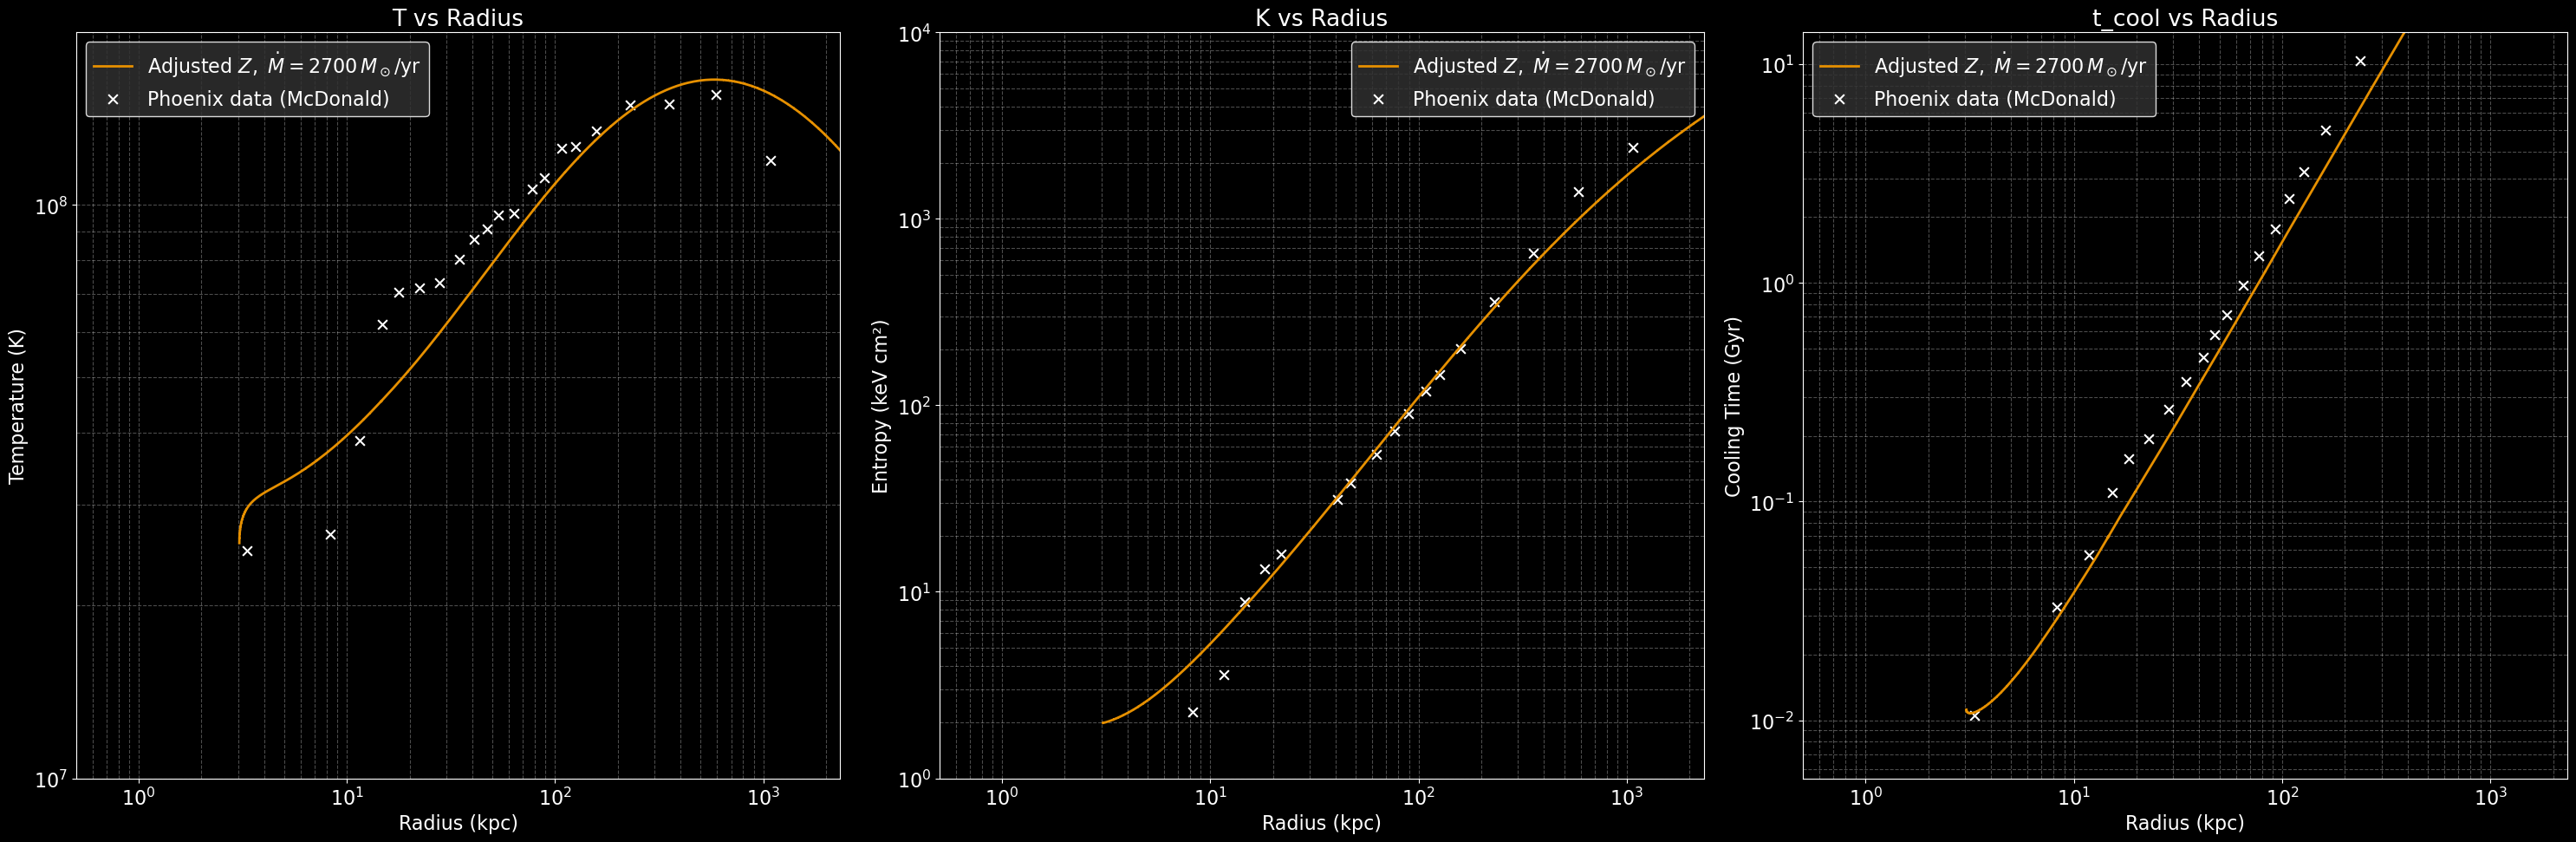

In [68]:
plt.rcParams.update({'font.size': 16})

runs = [
    (-1,    Mdot1 * 2700)
]

colors = ["#e69000", "#00e699", "#9900e6"]
labels = [
    r"$\mathrm{Adjusted}\ Z,\ \dot{M} = 2700\,M_\odot/\mathrm{yr}$"
]

results = []
for (Lambdatype, Mdot), label in zip(runs, labels):
    try:
        x, R0, v0, T0, recorder = BrentLooper(Mdot, 1 * ktc, 10 * ktc, Lambdatype)
        results.append((label, recorder))
    except Exception as e:
        print(f"Failed for {label}: {e}")

fig, axes = plt.subplots(1, 3, figsize=(30, 10), sharex=True)

# Make background black
fig.patch.set_facecolor('black')

for (label, recorder), color in zip(results, colors):
    r_kpc = np.array(recorder["ra2"]) / ktc
    T     = np.array(recorder["Tarray"])
    rho   = np.array(recorder["rhoarray"])
    tcool = np.array(recorder["tcool"]) / 3.1536e16
    K     = (rho/mp_g)**(-2/3) * k_Bcgs * T * etkv

    axes[0].plot(r_kpc, T, color=color, label=label, linewidth=2)
    axes[1].plot(r_kpc, K, color=color, label=label, linewidth=2)
    axes[2].plot(r_kpc, tcool, color=color, label=label, linewidth=2)

axes[0].scatter(Tmpx, Tmpy, s=60, marker='x', color='white', label='Phoenix data (McDonald)')
axes[1].scatter(x_values, y_values, s=60, marker='x', color='white', label='Phoenix data (McDonald)')
axes[2].scatter(tcoolr, tcooly, s=60, marker='x', color='white', label='Phoenix data (McDonald)')

for ax, ylabel, title in zip(
    axes,
    ['Temperature (K)', 'Entropy (keV cm²)', 'Cooling Time (Gyr)'],
    ['T vs Radius', 'K vs Radius', 't_cool vs Radius']
):
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'Radius (kpc)', color='white')
    ax.set_ylabel(ylabel, color='white')
    ax.set_title(title, color='white')
    ax.set_xlim(0.5, 2340)
    ax.grid(True, which='both', ls='--', color='white', alpha=0.3)

    ax.tick_params(colors='white')

    # Black background for axes
    ax.set_facecolor('black')
    for spine in ax.spines.values():
        spine.set_color('white')

# Legend with dark gray background
for ax in axes:
    legend = ax.legend()
    for text in legend.get_texts():
        text.set_color('white')
    legend.get_frame().set_edgecolor('#ffffff')
    legend.get_frame().set_facecolor('#303030')
    legend.get_frame().set_alpha(0.85)

axes[0].set_ylim(1e7, 2e8)
axes[1].set_ylim(1, 1e4)
axes[2].set_ylim(None, 14)

plt.tight_layout()
plt.show()

In [ ]:
temper = np.array([
    1075.58706, 1075.58706,  583.20708, 591.76857, 350.19005, 350.19005,
    229.48774, 226.16759, 157.10953, 157.10953, 124.43333, 124.43333,
    106.00258, 106.00258, 88.99530, 88.99530, 75.81355, 75.81355,
    63.64986, 63.64986, 53.43774, 53.43774, 46.86904, 46.86904,
    40.51305, 40.51305, 34.01305, 34.01305, 27.33436, 27.33436,
    21.64926, 21.64926, 17.65369, 17.91284, 14.60686, 14.60686,
    11.40150, 11.40150, 8.15441, 8.15441, 3.11653, 3.11653
])

tempey = np.log10(np.array([
    8.36975, 15.39496, 14.85714, 12.30252, 14.55462, 12.00000,
    13.24370, 12.30252, 12.03361, 10.92437, 11.52941, 10.48739,
    11.46218, 10.35294, 10.08403, 9.04202, 9.54622, 8.70588,
    8.57143, 8.03361, 8.43697, 8.00000, 8.13445, 7.46218,
    7.83193, 7.19328, 7.05882, 6.78992, 6.55462, 6.11765,
    6.58824, 5.91597, 6.31933, 5.74790, 5.64706, 5.04202,
    3.83193, 3.19328, 2.45378, 2.18487, 2.35294, 1.81513
])*kevtk)

tempey_pairs = tempey.reshape(-1, 2)

Terrors = np.abs(tempey_pairs[:,0] - tempey_pairs[:, 1]) /2
Tstdvi = Terrors**2
Tstdvi = Tstdvi * (np.sum(Terrors)/np.sum(Tstdvi))
print(np.sum(Tstdvi))

In [ ]:
y = np.log10(np.array([3324.598, 1522.680, 1553.475, 1297.309, 725.888, 594.173, 374.898, 346.043, 214.010, 193.623, 155.348, 137.762, 127.159, 112.765,
    96.075, 85.199, 78.642, 69.739, 57.085, 51.647, 39.811, 35.304, 33.246, 30.079, 16.830, 14.925, 14.055, 12.716, 9.607, 8.185,
    4.228, 3.008, 2.563, 1.975]))

y_pairs = y.reshape(-1, 2)

# Compute symmetric error for each pair
errors = np.abs(y_pairs[:, 0] - y_pairs[:, 1]) / 2
stdvi = errors**2

y_kvalues = np.log10(np.array([2413.28546, 1405.48459, 656.73673, 360.18178, 201.53377, 146.29093, 119.74596, 90.47357, 72.58879, 54.84417, 38.24800, 31.30777, 
    15.84893, 13.23546, 8.86801, 3.60182, 2.27259]))

In [ ]:
def ChiSquaredCalc(Mdot, Lambdatype):
    x, R0, v0, T0, recorder = BrentLooper(Mdot*Mdot1, 1*ktc, 12*ktc, Lambdatype)
    rA = np.array(recorder["ra2"])
    TA = np.array(recorder["Tarray"])
    rhoA = np.array(recorder["rhoarray"])
    KA = (rhoA / (mu*mp_g))**(-2/3) * k_Bcgs * TA * etkv
    Kvals = []
    for j in range(len(x_values)):
        idx = np.argmin(np.abs(rA - x_values[j]*ktc))
        Kvals.append(np.log10(KA[idx]))
    sqdiff = (Kvals - y_kvalues)**2
    print(np.sum(sqdiff/stdvi)/16)
    return sqdiff / stdvi

In [ ]:
def TChiSquaredCalc(Mdot, Lambdatype):
    x, R0, v0, T0, recorder = BrentLooper(Mdot*Mdot1, 1*ktc, 12*ktc, Lambdatype)
    rA = np.array(recorder["ra2"])
    TA = np.array(recorder["Tarray"])
    Tvals = []
    for j in range(len(Tmpx)):
        idx = np.argmin(np.abs(rA - Tmpx[j]*ktc))
        Tvals.append(np.log10(TA[idx]))
    sqdiff = (Tvals - np.log10(Tmpy))**2
    print(np.sum(sqdiff))
    return sqdiff / Tstdvi

In [ ]:
all_n = []
all_chi2 = []
for i in np.linspace(2000, 3500, 5):
    results = TChiSquaredCalc(i, -1)
    chi2 = np.sum(results)
    all_n.append(i)
    all_chi2.append(chi2 / 20)

plt.plot(all_n, all_chi2, marker='o')
plt.xlabel("Mdot scaling factor (n)")
plt.ylabel("Reduced χ²")
plt.title("Model Fit vs. Mass Flux")
plt.grid(True)
plt.show()

In [ ]:
all_n = []
all_chi2 = []
for i in np.linspace(1000, 2250, 8):
    results = ChiSquaredCalc(i, -1)
    chi2 = np.sum(results)
    all_n.append(i)
    all_chi2.append(chi2 / 16)

plt.plot(all_n, all_chi2, marker='o')
plt.xlabel("Mdot scaling factor (n)")
plt.ylabel("Reduced χ²")
plt.title("Model Fit vs. Mass Flux")
plt.grid(True)
plt.show()

In [ ]:
# Adjustable resolution
N_RES = 2

# Parameter ranges
M_vals = np.linspace(2000, 4000, N_RES)
Z_vals = np.linspace(0.2, 0.35, N_RES)

# Initialize 2D grid for reduced chi-squared values
chi2_grid = np.zeros((N_RES, N_RES))

# Evaluate ChiSquaredCalc at each (n, Z)
for i, n in enumerate(M_vals):
    for j, Z in enumerate(Z_vals):
        try:
            chi2 = ChiSquaredCalc(n, Z).sum() / 16
        except Exception as e:
            chi2 = np.nan
        chi2_grid[i, j] = chi2

plt.figure(figsize=(8, 6))
pcm = plt.pcolormesh(Z_vals, M_vals, chi2_grid, shading='auto', cmap='plasma')

plt.xlabel("Metallicity (Z)")
plt.ylabel("Mdot Scaling Factor (n)")
plt.title("Reduced χ² Across Mdot and Z")
cbar = plt.colorbar(pcm, label=r"$\chi^2_{\nu}$")
plt.grid(True, which='both', ls='--', lw=0.3)
plt.tight_layout()
plt.show()

min_idx = np.unravel_index(np.nanargmin(chi2_grid), chi2_grid.shape)
best_n = M_vals[min_idx[0]]
best_Z = Z_vals[min_idx[1]]
best_chi2 = chi2_grid[min_idx]

print(f"Best fit → Mdot: {best_n:.2f}, Z: {best_Z:.3f}, Reduced χ²: {best_chi2:.4f}")